# Data Analysis Report

## Overview
New Muzz users are asked to verify their phone number as an initial layer of security. This involves having the user receive a one-time password (OTP) that they are then required to submit successfully to move onto the next layer of security and begin building their profiles. This report analyses the effectiveness of three different verification approaches: SMS Only, SMS Primary (with WhatsApp as an alternative), and WhatsApp Primary (with SMS as an alternative). Using sample data from an ABC test, we evaluate these methods based on verification success rates, cost efficiency, and user adoption to determine the best verification strategy.


## Setup
We begin by setting up our environment by installing the relevant packages and loading in our datasets. We have also configured the pandas display option to ensure better data visibility during our analysis. Our datasets include:

- `verification.csv`: Contains verification-related data
- `profiles.csv`: Contains profile information
- `costs.csv`: Contains cost-related data

In [93]:
# Install packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 1000)

# Read in data
verification = pd.read_csv('verification.csv')
profiles = pd.read_csv('profiles.csv')
costs = pd.read_csv('costs.csv')

## Data Preview

A quick look at our datasets gives us a feel for the stucture of the datasets:

1. Verification Data (verification.csv)
  * Records which screen variant each user saw (A, B, or C)
  * Shows their chosen verification method (SMS or WhatsApp)
  * Tracks if verification was successful

2. User Profiles (profiles.csv)
  * Contains user demographics (gender, age, country)
  * Helps understand if certain user groups prefer different methods

3. Cost Data (costs.csv)
  * Shows SMS and WhatsApp costs by country
  * Helps evaluate the financial impact of each method

In [94]:
# View dataframe snippet
for name, df in [("Verification", verification), ("Profiles", profiles), ("Costs", costs)]:
    print(f"\n{'-'*50}")
    print(f"Data snippet for {name} Dataset:")
    print(f"{'-'*50}")
    print(df.head())


--------------------------------------------------
Data snippet for Verification Dataset:
--------------------------------------------------
                            userID group method  verified
0  mpr_2fHOBr0Nw6mNM2fPIKMeSyKUP0e     B    Sms         0
1  mpr_2fHOmoydcZfjF0UdFEmDQQifYK1     C    Sms         1
2  mpr_2fHRBhLrWEOcfjjblwatVXbnxoN     B    Sms         1
3  mpr_2fHQGGdXwbv8902hxC9C1dt1ThN     A    Sms         1
4  mpr_2fHSJ6Yyz6VC06GVQFjXH9q7s6m     A    Sms         1

--------------------------------------------------
Data snippet for Profiles Dataset:
--------------------------------------------------
                            userID gender                  dob country
0  mpr_2fOzSxcEMql0TQkeK2vGCuJBu9K      M  25 Oct, 2005, 00:00      CA
1  mpr_2fIcL4JraEe6OMdD4xvfVIZiAx8      M  10 Jun, 1978, 00:00      CA
2  mpr_2fHMFzUtfSXQORtB5anUIjuNQso      F  15 Feb, 2002, 00:00      GB
3  mpr_2fHaKh68oUhLyEZwztVzaCHefQ9      F  25 Aug, 2001, 00:00      FR
4  mpr_2fIJtYAsOQ

## Data Quality Checks

Our three datasets can be linked using userID and country codes. However, first let's verify that there are no missing values, duplicate ID's and take a look at our sample sizes. As part of our data quality checks we would also like to understand some of the following key metrics:

- ABC test group distribution
- Verification methods and success rates
- Gender split
- Date ranges for user ages
- Cost ranges for both methods

We can see from the output below that we have a large sample size of 18,424 users with no duplicate ID's and mostly complete data - only missing 3 country values in profiles. Interestingly, we see generally high verification success at `91%`, a gender skew of `62%` male vs `38%` female and a wide age range. We can also see that WhatsApp is generally cheaper than SMS with respective costs at `$0.008 - $0.440` per message vs `$0.026 - $0.086` per message.

In [95]:
# Data quality checks
for name, df in {'Verification': verification, 'Profiles': profiles, 'Costs': costs}.items():
    print(f"\n{'-'*50}")
    print(f"Checking {name} Dataset:")
    print(f"{'-'*50}")
    print("Missing values:", df.isnull().sum())
    print("Duplicate keys:", df[df.columns[0]].duplicated().sum())
    print("Row count:", len(df))
    
    if name == 'Verification':
        print("\nKey metrics:")
        print("Groups:", verification['group'].unique())
        print("Methods:", verification['method'].unique())
        print("Verification rates:", verification['verified'].value_counts(normalize=True))
    
    elif name == 'Profiles':
        print("\nKey metrics:")
        print("Gender distribution:", profiles['gender'].value_counts())
        print("Date range:", 
              f"From: {pd.to_datetime(profiles['dob']).min():%Y-%m-%d}",
              f"To: {pd.to_datetime(profiles['dob']).max():%Y-%m-%d}")
    
    elif name == 'Costs':
        print("\nKey metrics:")
        print("SMS cost range: ${:.3f} to ${:.3f}".format(
            costs['sms_usd'].min(), costs['sms_usd'].max()))
        print("WhatsApp cost range: ${:.3f} to ${:.3f}".format(
            costs['whatsapp_usd'].min(), costs['whatsapp_usd'].max()))


--------------------------------------------------
Checking Verification Dataset:
--------------------------------------------------
Missing values: userID      0
group       0
method      0
verified    0
dtype: int64
Duplicate keys: 0
Row count: 18424

Key metrics:
Groups: ['B' 'C' 'A']
Methods: ['Sms' 'Whatsapp']
Verification rates: 1    0.90914
0    0.09086
Name: verified, dtype: float64

--------------------------------------------------
Checking Profiles Dataset:
--------------------------------------------------
Missing values: userID     0
gender     0
dob        0
country    3
dtype: int64
Duplicate keys: 0
Row count: 18424

Key metrics:
Gender distribution: M    11387
F     7037
Name: gender, dtype: int64
Date range: From: 1938-09-16 To: 2006-04-21

--------------------------------------------------
Checking Costs Dataset:
--------------------------------------------------
Missing values: country         0
whatsapp_usd    0
sms_usd         0
dtype: int64
Duplicate keys: 0
Row

## Merging datasets

We can merge the datasets and verify that there was no data loss.

In [96]:
# Merge dataframes
verification_profiles = verification.merge(profiles, on='userID', how='left')
final_df = verification_profiles.merge(costs, on='country', how='left')

# Validate no data loss
print("Verification records:", len(verification))
print("Final merged records:", len(final_df))

Verification records: 18424
Final merged records: 18424


## Analysis

To determine the most effective verification screen, let's analyse:

1. Success Metrics
- Verification success rates across A/B/C groups
- User preferences for SMS vs WhatsApp
- Cost per successful verification

2. User Behavior
- Method selection patterns
- Impact on different user segments
- Regional variations

## Success Metrics

The analysis reveals Group C (WhatsApp Primary) is the most effective verification approach. This is because although groups B and C both achieve `92.8%` verification success, group C costs `$0.057` per successful verification (`43%` cheaper than group A at `$0.101` and `38%` cheaper than group B at `$0.092`). Group A lags behind at `87.3%` verification success rate. The sample sizes are well balanced across our groups with ~6000 users each. We can also see that WhatsApp and SMS showed similar success rates at `91.4%` vs `90.8%`, but the cost advantage of WhatsApp makes it the preferred choice.

In [97]:
# Verification success rates
print("Success Rates by Variant:")
success_by_group = final_df.groupby('group')['verified'].agg(['mean', 'count'])
print(success_by_group.round(3))

# User preferences & success by method
print("\nVerification Success by Method:")
method_success = final_df.groupby('method')['verified'].mean()
print(method_success.round(3))

# Cost per successful verification
print("\nCost per Successful Verification:")
final_df['verification_cost'] = np.where(
   final_df['method'] == 'Sms', 
   final_df['sms_usd'], 
   final_df['whatsapp_usd']
)
cost_success = final_df[final_df['verified'] == 1].groupby('group')['verification_cost'].mean()
print(cost_success.round(3))

Success Rates by Variant:
        mean  count
group              
A      0.873   6382
B      0.928   5924
C      0.928   6118

Verification Success by Method:
method
Sms         0.908
Whatsapp    0.914
Name: verified, dtype: float64

Cost per Successful Verification:
group
A    0.101
B    0.092
C    0.057
Name: verification_cost, dtype: float64


## User Behaviour
The analysis reveals some interesting user behaviour insights as follows:

1. Method Selection
- Group A (SMS Only): `100%` chose SMS (as expected)
- Group B (SMS Primary): Strong preference for SMS (`89%`) despite WhatsApp option
- Group C (WhatsApp Primary): `64%` chose WhatsApp, suggesting placement matters

2. Gender Impact
- All variants perform slightly better with female users
- Groups B and C show nearly identical success rates at `92%`
- Group A performs worst for both genders (`~87-89%`)

3. Regional Patterns:
- Top 5 markets: Morocco, France, Pakistan, US, Indonesia
- Success rates consistently high (`89-94%`)
- Expensive: Indonesia (`$0.141`), Pakistan (`$0.135`), Economical: US (`$0.014`), France (`$0.039`)

These insights suggest user location significantly impacts costs, while gender has less of an effect on verification rates in this sample.

In [98]:
# Method selection patterns
print("Method Selection by Variant:")
method_selection = pd.crosstab(final_df['group'], final_df['method'], normalize='index')
print(method_selection.round(3))

# Impact on user segments (gender)
print("\nSuccess Rates by Gender and Variant:")
gender_success = final_df.groupby(['group', 'gender'])['verified'].mean()
print(gender_success.round(3))

# Regional patterns
print("\nTop 5 Countries by Verification Volume:")
country_stats = final_df.groupby('country').agg({
   'verified': ['count', 'mean'],
   'verification_cost': 'mean'
}).sort_values(('verified', 'count'), ascending=False).head()
print(country_stats.round(3))

Method Selection by Variant:
method    Sms  Whatsapp
group                  
A       1.000     0.000
B       0.887     0.113
C       0.362     0.638

Success Rates by Gender and Variant:
group  gender
A      F         0.885
       M         0.866
B      F         0.939
       M         0.921
C      F         0.940
       M         0.921
Name: verified, dtype: float64

Top 5 Countries by Verification Volume:
        verified        verification_cost
           count   mean              mean
country                                  
MA          2037  0.894             0.096
FR          1589  0.935             0.039
PK          1570  0.896             0.135
US          1311  0.927             0.014
ID          1162  0.889             0.141


## Conclusion & Recommendation

Looking at the analysis, the recommended choice is to go with group C (WhatsApp Primary) as it offers the highest verification success rate at `92.8%` relative to cost per successful verification demonstrated by the graph below. Although Group C is our best option, our analysis also showed that regional customisation could further optimise both user experience and costs. Our investigation into 'User Behaviour' showed us that there was a significant variation in costs dependant on user location, which could suggest an even better choice might be to have a dynamic screen dependent on a user's geographical location.

To further optimise our verification process and better understand user behavior patterns, we could collect additional metrics beyond just success rates and costs. These metrics would include:
- Time to complete verification for each method
- Failed verification reasons
- User feedback/satisfaction scores
- Device types and operating systems

Based on the current analysis and the potential insights from additional metrics, we could consider another verification option such as email which would offer users some device flexibility, is not as dependent on mobile network coverage and could be a significantly cheaper option. It's clear that users prefer having optionality over strictly SMS in our sample data.

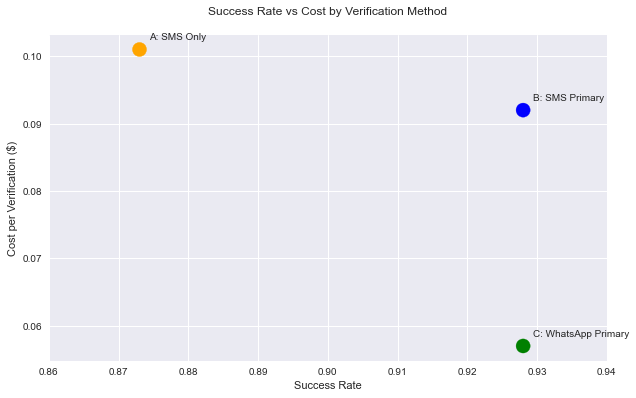

In [99]:
# Create data for scatter plot
groups = ['A: SMS Only', 'B: SMS Primary', 'C: WhatsApp Primary']
success_rates = [0.873, 0.928, 0.928]
costs = [0.101, 0.092, 0.057]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(success_rates, costs, s=200, c=['orange', 'blue', 'green'])
for i, group in enumerate(groups):
    plt.annotate(group, 
                (success_rates[i], costs[i]),
                xytext=(10, 10), 
                textcoords='offset points')
plt.xlabel('Success Rate')
plt.ylabel('Cost per Verification ($)')
plt.title('Success Rate vs Cost by Verification Method', pad=20)
plt.xlim(0.86, 0.94)
plt.show()